# This notebook demonstrates how to use a synthetic PSF to deconvolve an image

In [4]:
import nustar_gen.radial_profile as radial_profile
from nustar_gen.wrappers import make_image, make_spectra
from nustar_gen import info

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np

import regions
import astropy.units as u

import os
from scipy import ndimage


<module 'nustar_gen.radial_profile' from '/Users/bwgref/science/local/git/nustar-gen-utils/nustar_gen/radial_profile.py'>

In [5]:
obs = info.Observation(path=os.getcwd(), seqid='60501018002')
print(obs.path)
print(obs.seqid)
print(obs.evdir)
print(obs.out_path)

/Users/bwgref/science/psf_deconvolution
60501018002
/Users/bwgref/science/psf_deconvolution/60501018002/event_cl
/Users/bwgref/science/psf_deconvolution/60501018002/event_cl


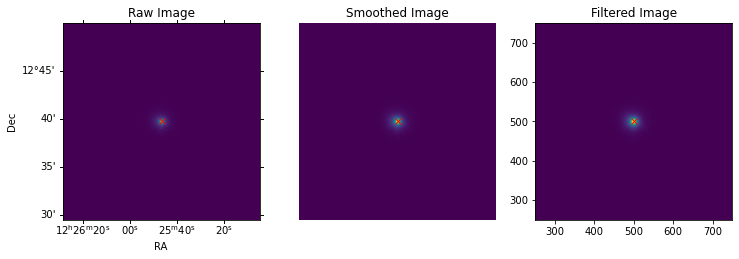

/Users/bwgref/science/psf_deconvolution/60501018002/event_cl/runspec_nu60501018002A01_srcA.sh


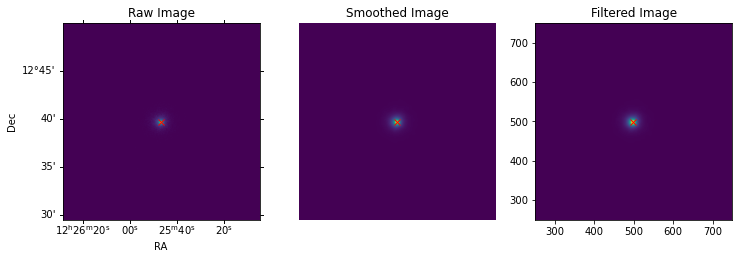

/Users/bwgref/science/psf_deconvolution/60501018002/event_cl/runspec_nu60501018002B01_srcB.sh


In [6]:
# Preprocessing happens here.

mods = ['A', 'B']
for mod in mods:
    
    infile = obs.evtfiles[mod][0]
    full_range = make_image(infile, elow = 3, ehigh = 10, clobber=True)
    coordinates = radial_profile.find_source(full_range, show_image = True, filt_range=3)

    srcx = coordinates[0][0]
    srcy = coordinates[0][1]
    
    # Get the WCS header and convert the pixel coordinates into an RA/Dec object
    hdu = fits.open(full_range, uint=True)[0]
    wcs = WCS(hdu.header)

    # The "flip" is necessary to go to [X, Y] ordering from native [Y, X] ordering, which wcs uses
    world = wcs.all_pix2world(np.flip(coordinates), 0)
    ra = world[0][0]
    dec = world[0][1]
    target = SkyCoord(ra, dec, unit='deg', frame='fk5')
    obj_j2000 = SkyCoord(hdu.header['RA_OBJ'], hdu.header['DEC_OBJ'], unit = 'deg', frame ='fk5')

    # How far are we from the J2000 coordinates? If <15 arcsec, all is okay
    sep = target.separation(obj_j2000)
    

    # For now, we are going to just make a simple source region
    source_reg = regions.CircleSkyRegion(center=target, radius=60*u.arcsec)
    outfile = os.path.join(obs.out_path, f'src{mod}.reg')
    source_reg.write(outfile, radunit='arcsec', overwrite=True, format = 'ds9')
    
    
    shfile = make_spectra(infile, mod, outfile, oa_hist=True, outpath=obs.out_path)
    print(shfile)
    


In [7]:
# Make the effective PSFs here
for mod in mods:
    oahist = os.path.join(obs.out_path, f'nu60501018002{mod}01_src{mod}_offaxishisto.fits')
    radial_profile.make_obs_psf(oahist, mod, out_dir=obs.out_path)
    

# Below are example for how to do deconvolution.

Please note that there are *many* options for doing image deconvolution. In this example we will use the Richardson-Lucy implementation in scikit-image (skimage). The flux calibration of these images is left to the user.

In [8]:
# Now do the deconvolution.

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration, transform
import skimage
import numpy as np

from matplotlib import pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits

In [13]:
mod = 'B'
rawdata, hdr= fits.getdata(os.path.join(obs.out_path, f'nu60501018002{mod}01_cl_3to10keV.fits'), header=True)
psf_rot = fits.getdata(os.path.join(obs.out_path, f'psf2d_obs_5.25keV_{mod}.fits'))

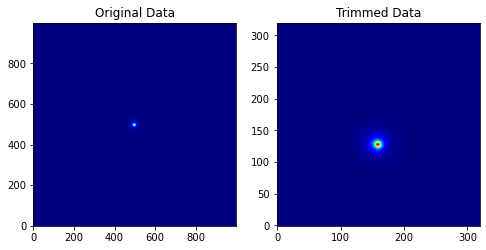

In [14]:
# Adjust centerx / centery and sizex /sizey to fit the source

trim_raw = rawdata.copy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
plt.jet()

ax[0].imshow(rawdata, origin='lower')
ax[0].set_title('Original Data')


centery = 530
sizey = 160
min_indy = centery-sizey
max_indy = centery+sizey

centerx = 500
sizex = 160
min_indx = centerx-sizex
max_indx = centerx+sizex

trim_raw = trim_raw[min_indy:max_indy, min_indx:max_indx]
ax[1].imshow(trim_raw, origin = 'lower')
ax[1].set_title('Trimmed Data')

plt.show()


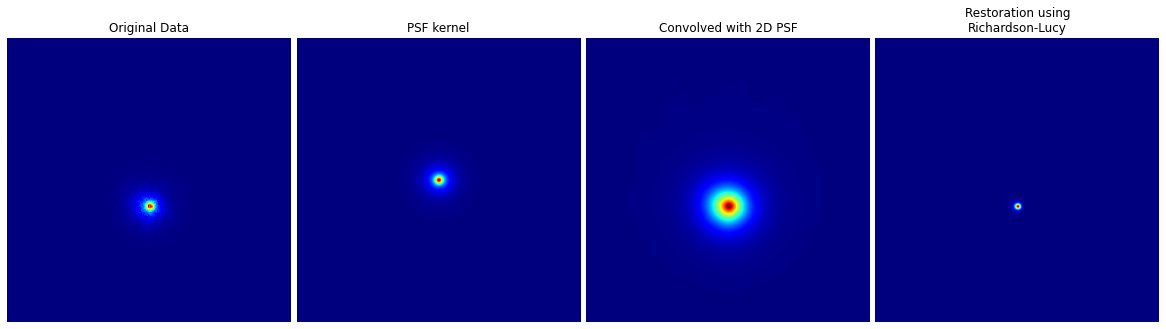

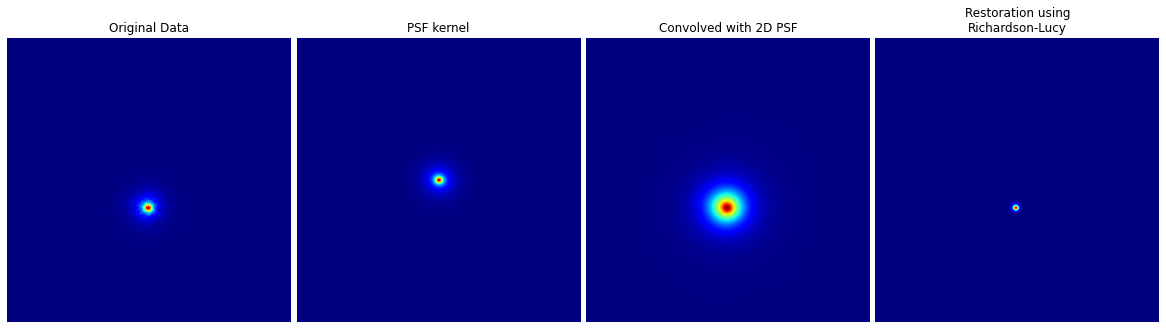

In [19]:

# Use the same values to produce a trimmed file

for mod in ['A', 'B']:
    
    rawdata, hdr= fits.getdata(os.path.join(obs.out_path, f'nu60501018002{mod}01_cl_3to10keV.fits'), header=True)
    psf_rot = fits.getdata(os.path.join(obs.out_path, f'psf2d_obs_5.25keV_{mod}.fits'))
    trim_raw = rawdata.copy()
    trim_raw = trim_raw[min_indy:max_indy, min_indx:max_indx]

    hdu = fits.open(os.path.join(obs.out_path, f'nu60501018002{mod}01_cl_3to10keV.fits'))[0]
    this_wcs = WCS(hdu.header)
    image_data = hdu.data

    this_wcs.wcs.crval = this_wcs.wcs_pix2world(centerx, centery, 1)

    this_wcs.wcs.crpix[0] = sizex
    this_wcs.wcs.crpix[1] = sizey

    hdr2 = this_wcs.to_header()

    trim_file = os.path.join(obs.out_path, f'trim_image{mod}.fits')
    fits.writeto(trim_file, trim_raw, hdr2, overwrite=True)

    # Smooth the file using the PSF
    sky_im = conv2(trim_raw, psf_rot, 'same')
    smooth_file = os.path.join(obs.out_path, f'smooth_image{mod}.fits')
    fits.writeto(smooth_file, sky_im, hdr, overwrite=True)

    # Deconvolution happens here
    deconv_data = restoration.richardson_lucy(trim_raw / trim_raw.max(), psf_rot, num_iter=50, clip=False)
    fits.writeto(os.path.join(obs.out_path,f'deconv_image{mod}.fits'), deconv_data, hdr2, overwrite=True)


    # Make some plots to see what happened

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 10))
    plt.jet()

    for a in (ax[0], ax[1], ax[2], ax[3]):
           a.axis('off')

    ax[0].imshow(trim_raw, origin='lower')
    ax[0].set_title('Original Data')

    ax[1].imshow(psf_rot, origin='lower')
    ax[1].set_title('PSF kernel')

    fits.writeto('psf_kernel.fits', psf_rot, hdr2, overwrite=True)


    ax[2].imshow(sky_im, vmin=sky_im.min(), vmax=sky_im.max(), origin='lower')
    ax[2].set_title('Convolved with 2D PSF')


    ax[3].imshow(deconv_data,origin='lower')
    ax[3].set_title('Restoration using\nRichardson-Lucy')


    fig.subplots_adjust(wspace=0.02, hspace=0.2,
                        top=0.9, bottom=0.05, left=0, right=1)
    plt.show()



# Now you can go look in ds9 to see how things turned out.

From anecdotal evidence, FPMA generally seems to have some residuals at the few % level, while FPMB looks a bit more point-like. However, this type of analysis is *extremely* sensitive to things like the number of interations, how well centered the kernel is, etc. This is very much not plug and play, so we encourage the user to exercise caution when interpreting results.

I have also made some choices about normalizing the images, so the resulting deconvolved images *will not be properly flux calibrated*. Figuring out how to do this is an exercise left to the user.

An example in ds9 with a log stretch after 100 iterations is shown below where FPMA is on the left and FPMB is on the right.


<img src="./example_data/deconv_screenshot.png" alt="Drawing" style="width: 800px;"/>